In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
import json
from urllib.error import URLError,HTTPError
import time
from pathlib import Path

In [2]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    print(f'searching for {term}')
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

In [3]:
# create DIR for notebook and set current DIR
NOTEBOOK_DIR = "Deployment/bearmodel"
Path(NOTEBOOK_DIR).mkdir(parents=True, exist_ok=True)

searching for grizzly bear


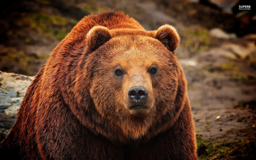

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

dest = NOTEBOOK_DIR + '/grizzlybear.jpg'
urls = search_images_ddg("grizzly bear", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

searching for back bear


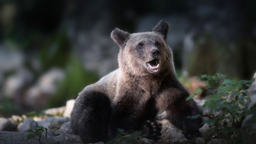

In [5]:
dest = NOTEBOOK_DIR + '/blackbear.jpg'
urls = search_images_ddg("back bear", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

In [8]:
dest = NOTEBOOK_DIR + '/teddybear.jpg'
urls = search_images_ddg("teddy bear", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

searching for teddy bear


HTTPError: HTTP Error 404: Not Found
====Error Body====

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">
<html>
<head>
<title>404 - URL Error</title>
<link rel="STYLESHEET" type="text/css" href="/waroot/style.css">
</head>
<body>
<h1>URL Not Found</h1>
<img src="/waroot/system_arrow.gif" width="21" height="21" alt="" border="0">
<p class="system_info">
The requested URL is invalid.
</p>
<hr>
</body>
</html>


In [10]:
searches = ['grizzly', 'black', 'teddy']
path = Path(NOTEBOOK_DIR+'/images')

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{search} bear', max_images=60))
    time.sleep(10)
    resize_images(dest, max_size=400, dest=dest)
    print("Resized complete")
    
    
    

searching for grizzly bear
Resized complete
searching for black bear
Resized complete
searching for teddy bear
Resized complete


In [13]:
# remove failed images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [14]:
bear = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)


Load and create Dataloader with Path

In [15]:
dls = bear.dataloaders(path)

show some data from validation set

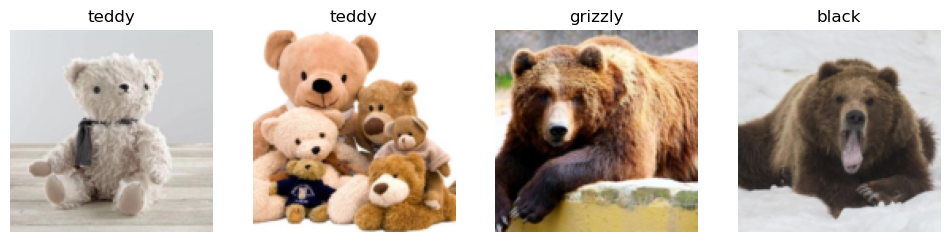

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

Show some data from trainining batch

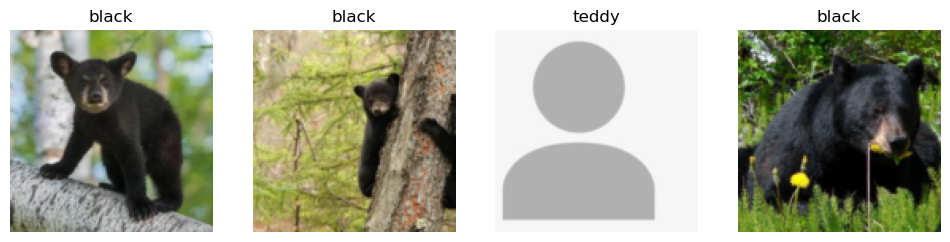

In [17]:
dls.train.show_batch(max_n=4, nrows=1)

By default **Resize** just crops the image to size requested. This can result is loss of feature. Padding and Squishing can be used to get squished/streched image to get all features. 

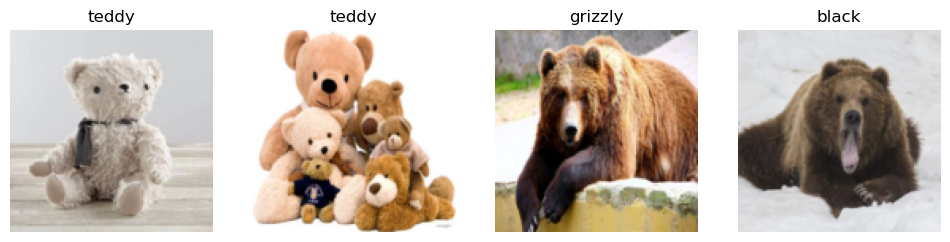

In [18]:
bear = bear.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bear.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

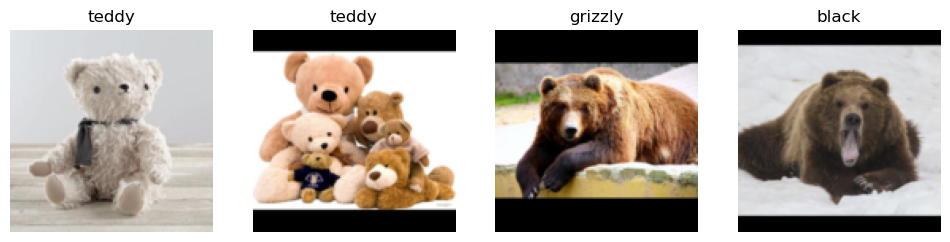

In [20]:
bear = bear.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bear.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)